In [1]:
import pandas as pd
df = pd.read_csv('Superstore.csv', usecols=["Order ID", "Order Date"])

In [2]:
df.drop_duplicates(subset=["Order ID"], inplace=True, ignore_index=True)

In [3]:
df.head()

,Order ID,Order Date
0,CA-2015-103800,2015-01-03
1,CA-2015-112326,2015-01-04
2,CA-2015-141817,2015-01-05
3,CA-2015-130813,2015-01-06
4,CA-2015-167199,2015-01-06


In [4]:
# Convert 'order_date' to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Extract the week number from 'order_date'
df['week'] = df['Order Date'].dt.isocalendar().week

# Group by week and count 'Order ID'
result = df.groupby('week')['Order ID'].count().reset_index()

# Rename the column
result.columns = ['week', 'number_of_order']
df = result.iloc[1:-1]
# df = result

In [5]:
df.head()

,week,number_of_order
1,2,36
2,3,40
3,4,35
4,5,54
5,6,43


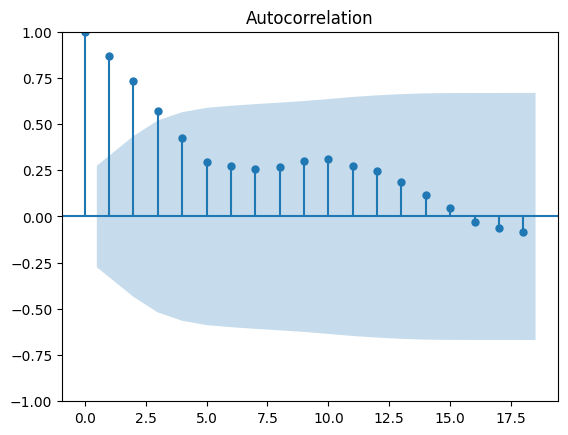

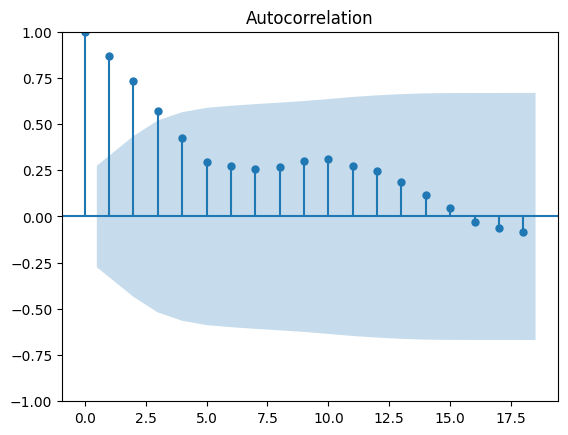

In [6]:
from statsmodels.graphics.tsaplots import plot_acf

# Plot the autocorrelation function for the 'value' column of the dataframe
plot_acf(df.number_of_order)


2     4.0
3    -5.0
4    19.0
5   -11.0
6    -3.0
Name: number_of_order, dtype: float64
Length before dropna: 51, after dropna: 50


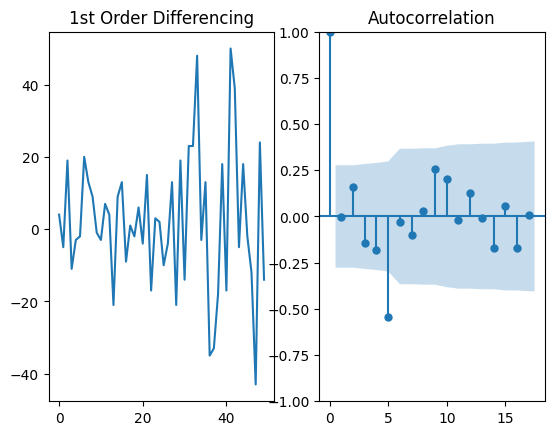

In [7]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Check if the 'value' column is numeric and inspect the diffed series
diff_series = df['number_of_order'].diff().dropna()

# Inspect before plotting
print(diff_series.head())
print(f"Length before dropna: {len(df['number_of_order'].diff())}, after dropna: {len(diff_series)}")

# If the diffed series is fine, proceed with plotting
f = plt.figure()

ax1 = f.add_subplot(121)
ax1.set_title('1st Order Differencing')

# Plot the differenced series, using .values for numpy array
ax1.plot(diff_series.values)

# Second subplot: Plot the ACF of the differenced series
ax2 = f.add_subplot(122)
plot_acf(diff_series, ax=ax2)

plt.show()


3    -9.0
4    24.0
5   -30.0
6     8.0
7     1.0
Name: number_of_order, dtype: float64
Length before dropna: 51, after dropna: 49


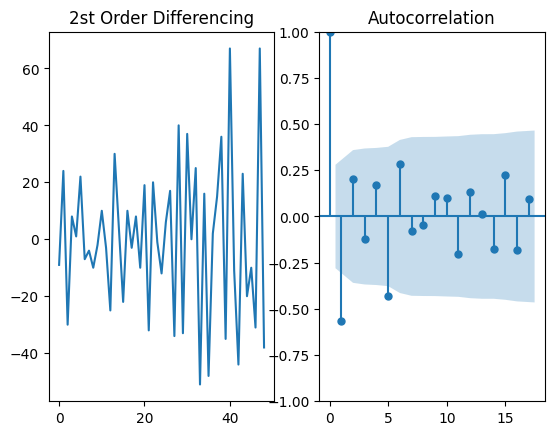

In [8]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Check if the 'value' column is numeric and inspect the diffed series
diff_series = df['number_of_order'].diff().diff().dropna()

# Inspect before plotting
print(diff_series.head())
print(f"Length before dropna: {len(df['number_of_order'].diff().diff())}, after dropna: {len(diff_series)}")

# If the diffed series is fine, proceed with plotting
f = plt.figure()

ax1 = f.add_subplot(121)
ax1.set_title('2st Order Differencing')

# Plot the differenced series, using .values for numpy array
ax1.plot(diff_series.values)

# Second subplot: Plot the ACF of the differenced series
ax2 = f.add_subplot(122)
plot_acf(diff_series, ax=ax2)

plt.show()


In [9]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df.number_of_order.dropna())
print('p-value: ', result[1])

result = adfuller(df.number_of_order.diff().dropna())
print('p-value: ', result[1])

result = adfuller(df.number_of_order.diff().diff().dropna())
print('p-value: ', result[1])

result = adfuller(df.number_of_order.diff().diff().diff().dropna())
print('p-value: ', result[1])


p-value:  0.9176652171207003
p-value:  1.0265476075918426e-09
p-value:  3.5348813285578845e-06
p-value:  3.0798931326895462e-06


In [10]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA model (order = (1, 1, 2))
arima_model = ARIMA(df.number_of_order, order=(3, 1, 2))
model = arima_model.fit()

# Print the summary
print(model.summary())


                               SARIMAX Results                                
Dep. Variable:        number_of_order   No. Observations:                   51
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -211.261
Date:                Wed, 25 Dec 2024   AIC                            434.523
Time:                        09:53:11   BIC                            445.995
Sample:                             0   HQIC                           438.891
                                 - 51                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0586      0.206      5.131      0.000       0.654       1.463
ar.L2         -0.2193      0.303     -0.724      0.469      -0.813       0.374
ar.L3         -0.4028      0.146     -2.766      0.0

/home/andv/VCS/visualization/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/andv/VCS/visualization/.venv/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


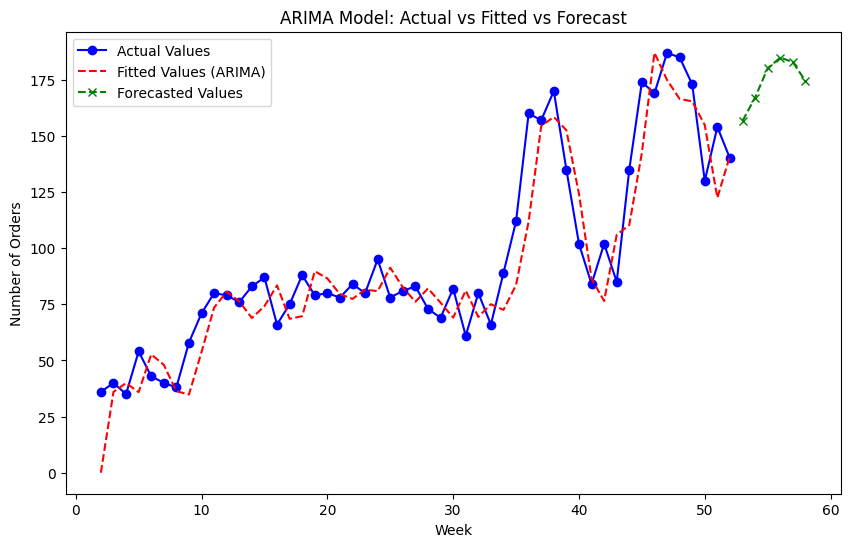

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Make predictions (fitted values)
fitted_values = model.fittedvalues

# Plot the actual vs fitted values
plt.figure(figsize=(10, 6))
plt.plot(df['week'], df['number_of_order'], label='Actual Values', color='blue', marker='o')
plt.plot(df['week'], fitted_values, label='Fitted Values (ARIMA)', color='red', linestyle='--')

# Optionally forecast future values (e.g., next 2 weeks)
forecast_steps = 6
forecast = model.forecast(steps=forecast_steps)
forecast_index = np.arange(df['week'].max() + 1, df['week'].max() + 1 + forecast_steps)

# Plot forecasted values
plt.plot(forecast_index, forecast, label='Forecasted Values', color='green', marker='x', linestyle='--')

# Add labels and legend
plt.title('ARIMA Model: Actual vs Fitted vs Forecast')
plt.xlabel('Week')
plt.ylabel('Number of Orders')
plt.legend()

# Show plot
plt.show()


In [12]:
import plotly.graph_objects as go
import numpy as np

# Prepare the data
weeks = df['week']
actual_values = df['number_of_order']
fitted_values = model.fittedvalues

# Forecast the future values
forecast_steps = 6
forecast = model.forecast(steps=forecast_steps)
forecast_index = np.arange(df['week'].max() + 1, df['week'].max() + 1 + forecast_steps)

# Create a plotly figure
fig = go.Figure()

# Add actual values as a scatter plot
fig.add_trace(go.Scatter(
    x=weeks,
    y=actual_values,
    mode='markers+lines',
    name='Actual Values',
    line=dict(color='blue'),
    marker=dict(symbol='circle', size=8),
    text=[f'Week {w}: {v}' for w, v in zip(weeks, actual_values)],  # Hover text
    hoverinfo='text'  # Show hover text when hovering
))

# Add fitted values (ARIMA model)
fig.add_trace(go.Scatter(
    x=weeks,
    y=fitted_values,
    mode='lines',
    name='Fitted Values (ARIMA)',
    line=dict(color='red', dash='dash'),
    text=[f'Week {w}: {v}' for w, v in zip(weeks, fitted_values)],  # Hover text
    hoverinfo='text'  # Show hover text when hovering
))

# Add forecasted values
fig.add_trace(go.Scatter(
    x=forecast_index,
    y=forecast,
    mode='markers+lines',
    name='Forecasted Values',
    line=dict(color='green'),
    marker=dict(symbol='x', size=10),
    text=[f'Week {w}: {v}' for w, v in zip(forecast_index, forecast)],  # Hover text
    hoverinfo='text'  # Show hover text when hovering
))

# Update layout
fig.update_layout(
    title='ARIMA Model: Actual vs Fitted vs Forecast',
    xaxis_title='Week',
    yaxis_title='Number of Orders',
    legend_title='Legend',
    hovermode='closest'  # Ensure hover shows info for closest point
)

# Show the plot
fig.show()
